In [1]:
import pandas as pd

In [2]:
#pip install git+https://github.com/quantopian/pyfolio
# import again if first time not work
import pyfolio

/home/host/course_work/machine_learning/stock_DRL/venv/lib/python3.6/site-packages/pyfolio-0.9.2+75.g4b901f6-py3.6.egg/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [3]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [4]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    print('Sharpe: ',(252**0.5)*df['daily_return'].mean()/ df['daily_return'].std())
    return df

In [5]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [6]:
def get_account_value(model_name):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        sum_temp = pd.read_csv('results_multi_portfolio_parts_ppo/account_value_trade_{}_{}_9.csv'.format(model_name,i))
        for j in range(9):
            temp = pd.read_csv('results_multi_portfolio_parts_ppo/account_value_trade_{}_{}_{}.csv'.format(model_name,i,j))
            sum_temp = temp + sum_temp
        df_account_value = df_account_value.append(sum_temp / 10,ignore_index=True)
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print(sharpe)
    df_account_value=df_account_value.join(df_trade_date[63:].reset_index(drop=True))
    return df_account_value

## DJIA

In [7]:
dji = pd.read_csv("data/^DJI.csv")
test_dji=dji[(dji['Date']>='2016-01-01') & (dji['Date']<='2020-06-30')]
test_dji = test_dji.reset_index(drop=True)

In [8]:
test_dji.shape

(1131, 7)

In [9]:
test_dji.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,17405.480469,17405.480469,16957.630859,17148.939453,17148.939453,148060000
1,2016-01-05,17147.500000,17195.839844,17038.609375,17158.660156,17158.660156,105750000
2,2016-01-06,17154.830078,17154.830078,16817.619141,16906.509766,16906.509766,120250000
3,2016-01-07,16888.359375,16888.359375,16463.630859,16514.099609,16514.099609,176240000
4,2016-01-08,16519.169922,16651.890625,16314.570313,16346.450195,16346.450195,141850000


In [10]:
test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)

In [11]:
dow_strat = backtest_strat(test_dji)

## Ensemble Strategy

In [12]:
df=pd.read_csv('data/dow_30_2009_2020.csv')

In [13]:
rebalance_window = 63
validation_window = 63
unique_trade_date = df[(df.datadate > 20151001)&(df.datadate <= 20200707)].datadate.unique()


In [14]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

In [15]:
ensemble_account_value = get_account_value('ensemble')

1.5765342352784275


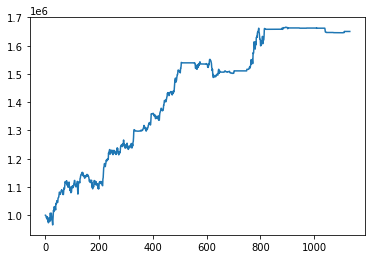

In [16]:
ensemble_account_value.account_value.plot()

In [17]:
ensemble_account_value = get_daily_return(ensemble_account_value)

Sharpe:  1.5765342352784275


In [18]:
ensemble_account_value['Date'] = test_dji['Date']

In [19]:
ensemble_account_value.head()

,account_value,datadate,daily_return,Date
0,1000000.000000,20160104,NaN,2016-01-04
1,999823.528504,20160105,-0.000176,2016-01-05
2,997423.577709,20160106,-0.002400,2016-01-06
3,992847.362172,20160107,-0.004588,2016-01-07
4,990333.240042,20160108,-0.002532,2016-01-08


In [20]:
ensemble_strat = backtest_strat(ensemble_account_value[0:1097])

In [21]:
#ensemble_account_value.to_csv('results/df_account_value_ensemble_daily_return.csv',index=False)

Start date,2016-01-04
End date,2020-05-12
Total months,52
,Backtest
Annual return,12.129%
Cumulative returns,64.601%
Annual volatility,7.354%
Sharpe ratio,1.60
Calmar ratio,2.39
Stability,0.90
Max drawdown,-5.075%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.08,2016-07-20,2016-09-14,2016-11-10,82
1,4.31,2016-06-09,2016-06-27,2016-07-08,22
2,4.14,2018-06-08,2018-06-27,2019-01-30,169
3,4.13,2016-02-04,2016-02-11,2016-02-17,10
4,3.78,2016-04-27,2016-05-19,2016-06-08,31


/home/host/course_work/machine_learning/stock_DRL/venv/lib/python3.6/site-packages/pyfolio-0.9.2+75.g4b901f6-py3.6.egg/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


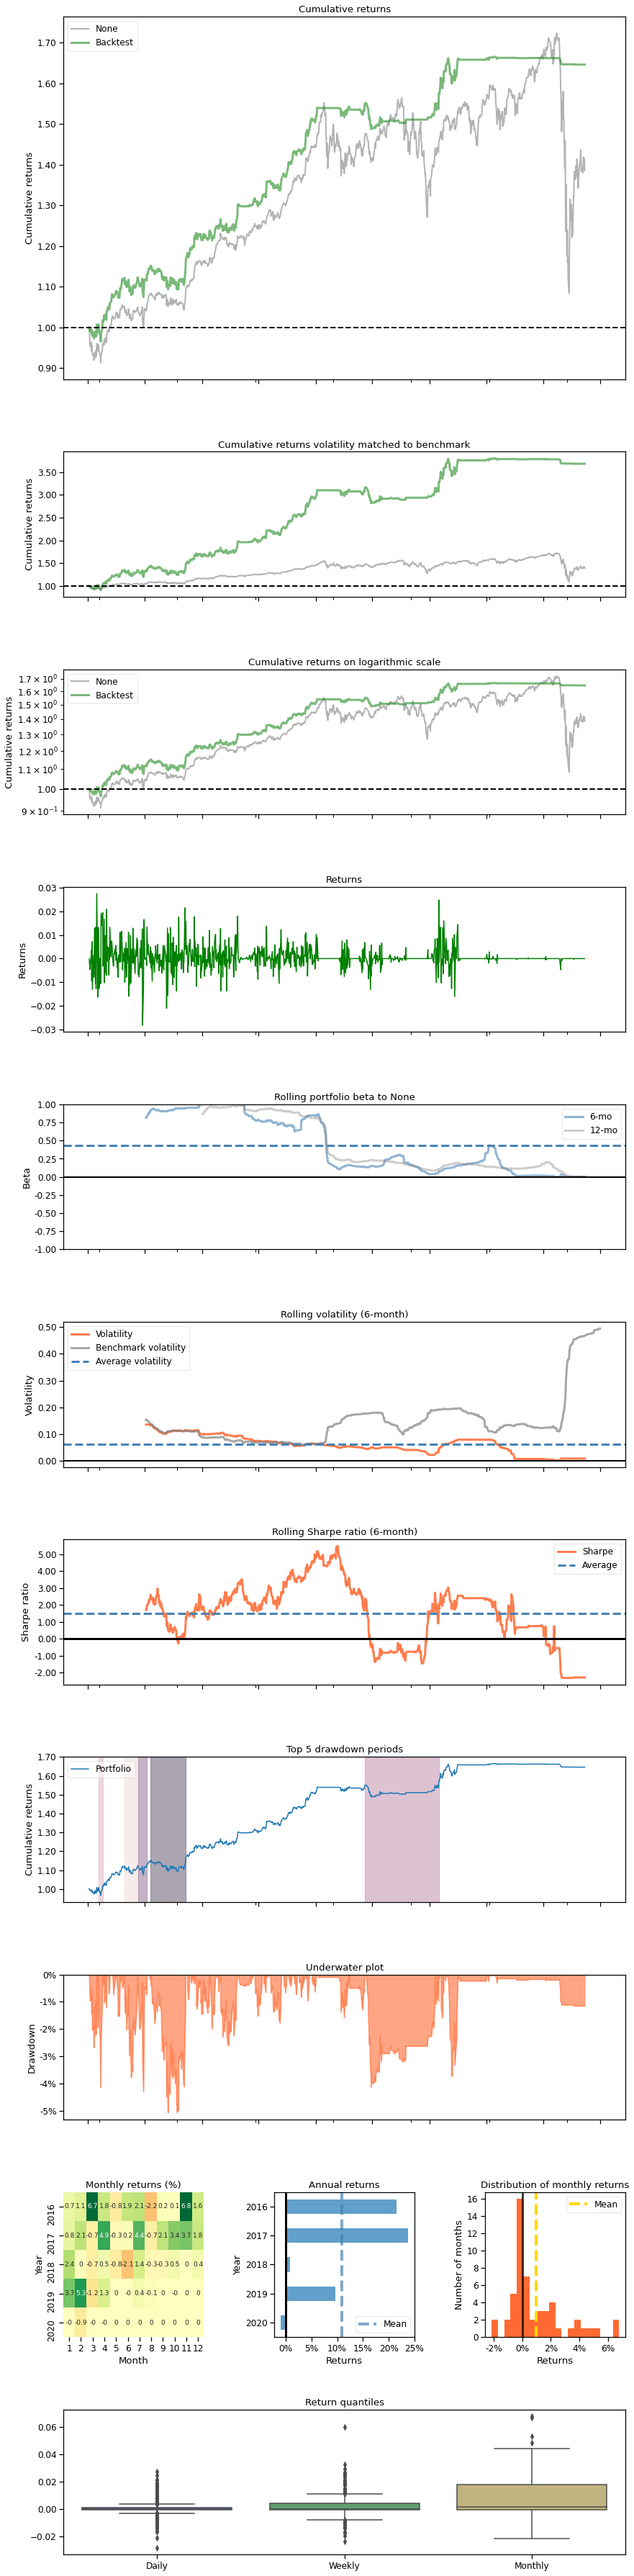

In [22]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = ensemble_strat,
                                   benchmark_rets=dow_strat, set_context=False)